In [5]:
#!pip install tensorflow==2.0.0

     |████████████████████████████████| 102.7 MB 1.8 MB/s            
  Preparing metadata (setup.py) ... done
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 3.8 MB 1.8 MB/s            
     |████████████████████████████████| 16.9 MB 3.6 MB/s            
     |████████████████████████████████| 126 kB 47 kB/s            
     |████████████████████████████████| 449 kB 131 kB/s            
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.0 MB 1.3 MB/s            
     |████████████████████████████████| 4.0 MB 6.7 MB/s            
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 3.1 MB 2.4 MB/s            
     |████████████████████████████████| 62 kB 2.4 MB/s            
     |█

In [21]:
!pip install keras==2.3.1

  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
     |████████████████████████████████| 189 kB 2.4 MB/s            
     |████████████████████████████████| 33.0 MB 3.7 MB/s            


In [ ]:
conda update -n base conda

Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ 

In [1]:
import tensorflow as tf

In [2]:
import sys

print("--sys.version—")
print(sys.version)

--sys.version—
3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [3]:
from __future__ import division, print_function


import collections
import itertools
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf


In [31]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [2]:
def get_data(infile):
    stories, questions, answers = [], [], []
    story_text = []
    fin = open(Train_File, "rb") 
    for line in fin:
        line = line.decode("utf-8").strip()
        lno, text = line.split(" ", 1)
        if "\t" in text:
            question, answer, _ = text.split("\t")
            stories.append(story_text)
            questions.append(question)
            answers.append(answer)
            story_text = []
        else:
            story_text.append(text)
    fin.close()
    return stories, questions, answers


In [5]:
file_location = "/Users/anseon-yeong/수업/2021-2/텍스트정보처리/week13/13주차_txt/"

Train_File = os.path.join(file_location, "qa1_single-supporting-fact_train.txt")
Test_File = os.path.join(file_location, "qa1_single-supporting-fact_test.txt")

data_train = get_data(Train_File)
data_test = get_data(Test_File)

print("\n\nTrain observations:",len(data_train[0]),"Test observations:", len(data_test[0]),"\n\n")




Train observations: 10000 Test observations: 10000 




In [6]:
data_test[0]

[['Mary moved to the bathroom.', 'John went to the hallway.'],
 ['Daniel went back to the hallway.', 'Sandra moved to the garden.'],
 ['John moved to the office.', 'Sandra journeyed to the bathroom.'],
 ['Mary moved to the hallway.', 'Daniel travelled to the office.'],
 ['John went back to the garden.', 'John moved to the bedroom.'],
 ['Sandra travelled to the office.', 'Sandra went to the bathroom.'],
 ['Mary went to the bedroom.', 'Daniel moved to the hallway.'],
 ['John went to the garden.', 'John travelled to the office.'],
 ['Daniel journeyed to the bedroom.', 'Daniel travelled to the hallway.'],
 ['John went to the bedroom.', 'John travelled to the office.'],
 ['Mary went to the bedroom.', 'John journeyed to the bathroom.'],
 ['Sandra journeyed to the hallway.', 'John journeyed to the garden.'],
 ['John journeyed to the bathroom.', 'Sandra journeyed to the garden.'],
 ['Sandra went back to the bedroom.', 'Daniel travelled to the bathroom.'],
 ['John went to the office.', 'Mary mo

In [ ]:
# 1. 전처리 : 사전을 만들고 스토리, 질문 및 답변을 vocab에 벡터 형식으로 매핑
# 2. 모델 개발 및 검증 : 딥러닝 모델 학습 후 검증 데이터 샘플을 테스트
# 3. 학습된 모델 기반 결과 예측 : 학습된 모델은 테스트 데이터의 결과를 예측 

In [7]:
#이야기의 모든 단어에 대해 질문 및 답변 데이터 매핑이 만들어지는 어휘사전을 만든다.
# 매핑은 단어를 정수로 변환한 다음 벡터 공간으로 변환하는데 사용 

#학습 및 테스트 데이터에서 vocab 딕셔너리 구축 

dictnry = collections.Counter()
for stories,questions,answers in [data_train,data_test]:
    for story in stories:
        for sent in story:
            for word in nltk.word_tokenize(sent):
                dictnry[word.lower()] +=1
    for question in questions:
        for word in nltk.word_tokenize(question):
            dictnry[word.lower()]+=1
    for answer in answers:
        for word in nltk.word_tokenize(answer):
            dictnry[word.lower()]+=1

word2indx = {w:(i+1) for i,(w,_) in enumerate(dictnry.most_common())}

word2indx["PAD"] = 0#공백정의
indx2word = {v:k for k,v in word2indx.items()}

vocab_size = len(word2indx)
print("vocabulary size:",len(word2indx))


vocabulary size: 22


In [25]:
#각 개체의 최대 시퀀스 길이 계산 
# 단어의 최대 길이를 알면 최대 길이의 벡터를 만들어보는 단어 길이를 통합 가능
story_maxlen = 0
question_maxlen = 0

for stories, questions, answers in [data_train,data_test]:
    for story in stories:
        story_len = 0
        for sent in story:
            swords = nltk.word_tokenize(sent)
            story_len += len(swords)
        if story_len > story_maxlen:
            story_maxlen = story_len
            
    for question in questions:
        question_len = len(nltk.word_tokenize(question))
        if question_len > question_maxlen:
            question_maxlen = question_len
            
print ("Story maximum length:",story_maxlen,"Question maximum length:",question_maxlen)

Story maximum length: 14 Question maximum length: 4


In [ ]:
#최대 단어 길이는 14 이며 질문의 경우는 4이다. 

In [9]:
word2indx

{'to': 1,
 'the': 2,
 '.': 3,
 'where': 4,
 'is': 5,
 '?': 6,
 'went': 7,
 'mary': 8,
 'john': 9,
 'sandra': 10,
 'daniel': 11,
 'bathroom': 12,
 'hallway': 13,
 'office': 14,
 'kitchen': 15,
 'garden': 16,
 'bedroom': 17,
 'journeyed': 18,
 'travelled': 19,
 'back': 20,
 'moved': 21,
 'PAD': 0}

In [22]:
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout, Permute
from keras.layers.embeddings import Embedding
from keras.layers.merge import add, concatenate, dot
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils


Using TensorFlow backend.


In [23]:
#데이터를 벡터화된 형태로 변환

def data_vectorization(data, word2indx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [[word2indx[w.lower()] for w in nltk.word_tokenize(s)] 
                                   for s in story]
        xs = list(itertools.chain.from_iterable(xs))
        xq = [word2indx[w.lower()] for w in nltk.word_tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2indx[answer.lower()])
    return pad_sequences(Xs, maxlen=story_maxlen), pad_sequences(Xq, maxlen=question_maxlen),\
           np_utils.to_categorical(Y, num_classes=len(word2indx))

In [26]:
Xstrain, Xqtrain, Ytrain = data_vectorization(data_train, word2indx, story_maxlen, question_maxlen)
Xstest, Xqtest, Ytest = data_vectorization(data_test, word2indx, story_maxlen, question_maxlen)

print("Train story",Xstrain.shape,"Train question", Xqtrain.shape,"Train answer", Ytrain.shape)
print( "Test story",Xstest.shape, "Test question",Xqtest.shape, "Test answer",Ytest.shape)


Train story (10000, 14) Train question (10000, 4) Train answer (10000, 22)
Test story (10000, 14) Test question (10000, 4) Test answer (10000, 22)


In [28]:
# Model Parameters

EMBEDDING_SIZE = 128
LATENT_SIZE = 64
BATCH_SIZE = 64
NUM_EPOCHS = 40

In [29]:
# 입력
story_input = Input(shape=(story_maxlen,))
question_input = Input(shape=(question_maxlen,))

# Story encoder embedding
story_encoder = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_SIZE,
                         input_length=story_maxlen)(story_input)
story_encoder = Dropout(0.2)(story_encoder)

# Question encoder embedding
question_encoder = Embedding(input_dim=vocab_size,output_dim=EMBEDDING_SIZE,
                            input_length=question_maxlen)(question_input)
question_encoder = Dropout(0.3)(question_encoder)

# 스토리와 질문의 일치
match = dot([story_encoder, question_encoder], axes=[2, 2])

# 이야기를 질문의 벡터 공간으로 인코딩
story_encoder_c = Embedding(input_dim=vocab_size,output_dim=question_maxlen,
                           input_length=story_maxlen)(story_input)
story_encoder_c = Dropout(0.3)(story_encoder_c)


# 일치한 내용과 스토리 벡터 결합
response = add([match, story_encoder_c])
response = Permute((2, 1))(response)

# 응답과 질문 벡터를 답변 공간에 결합 
answer = concatenate([response, question_encoder], axis=-1)
answer = LSTM(LATENT_SIZE)(answer)
answer = Dropout(0.2)(answer)
answer = Dense(vocab_size)(answer)
output = Activation("softmax")(answer)

model = Model(inputs=[story_input, question_input], outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])


print (model.summary())

2021-11-22 10:33:28.455158: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-11-22 10:33:28.471821: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb473690e50 executing computations on platform Host. Devices:
2021-11-22 10:33:28.471834: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 14, 128)      2816        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4, 128)       2816        input_4[0][0]                    
____________________________________________________________________________________________

In [30]:
history = model.fit([Xstrain, Xqtrain], [Ytrain], batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,validation_data=([Xstest, Xqtest], [Ytest]))

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 10000 samples
Epoch 1/40
10000/10000 [==============================] - 2s 157us/step - loss: 1.9782 - accuracy: 0.2126 - val_loss: 1.6331 - val_accuracy: 0.3039
Epoch 2/40
10000/10000 [==============================] - 1s 85us/step - loss: 1.6351 - accuracy: 0.3163 - val_loss: 1.5443 - val_accuracy: 0.4158
Epoch 3/40
10000/10000 [==============================] - 1s 86us/step - loss: 1.4840 - accuracy: 0.4534 - val_loss: 1.3678 - val_accuracy: 0.5287
Epoch 4/40
10000/10000 [==============================] - 1s 87us/step - loss: 1.3736 - accuracy: 0.5163 - val_loss: 1.2929 - val_accuracy: 0.5415
Epoch 5/40
10000/10000 [==============================] - 1s 85us/step - loss: 1.3143 - accuracy: 0.5201 - val_loss: 1.2465 - val_accuracy: 0.5424
Epoch 6/40
10000/10000 [==============================] - 1s 84us/step - loss: 1.2841 - accuracy: 0.5213 - val_loss: 1.2250 - val_accuracy: 0.5419
Epoch 7/40
10000/10000 [==============================] - 1s 85us/s

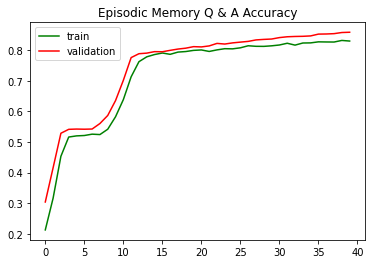

In [35]:
plt.title("Episodic Memory Q & A Accuracy")
plt.plot(history.history['accuracy'], color='g', label='train')
plt.plot(history.history['val_accuracy'], color='r', label='validation')
plt.legend(loc="best")
plt.show()

In [36]:
ytest = np.argmax(Ytest, axis=1)
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)


In [37]:
NUM_DISPLAY = 10
   
for i in random.sample(range(Xstest.shape[0]),NUM_DISPLAY):
    story = " ".join([indx2word[x] for x in Xstest[i].tolist() if x != 0])
    question = " ".join([indx2word[x] for x in Xqtest[i].tolist()])
    label = indx2word[ytest[i]]
    prediction = indx2word[ytest_[i]]
    print(story, question, label, prediction)


daniel travelled to the hallway . john went back to the bedroom . where is sandra ? office hallway
john journeyed to the bathroom . john journeyed to the kitchen . where is john ? kitchen kitchen
mary went to the bedroom . daniel moved to the hallway . where is sandra ? bathroom garden
mary went to the hallway . sandra went to the garden . where is daniel ? bedroom hallway
daniel moved to the hallway . daniel journeyed to the kitchen . where is daniel ? kitchen kitchen
john went back to the bedroom . mary went back to the hallway . where is sandra ? bathroom bathroom
mary went back to the office . daniel went to the bedroom . where is mary ? office office
john moved to the kitchen . daniel journeyed to the office . where is john ? kitchen kitchen
john moved to the bathroom . john went back to the office . where is john ? office office
mary went back to the bathroom . mary journeyed to the garden . where is mary ? garden garden
